## Image Generation Agent with cost Approval

### Scenario:

Build an agent that generates images using the MCP server, but requires approval for "bulk" image generation:

1. Single image request(1 image):Auto approve, generate immediately.
2. Bulk request (>1image): Pause and ask for approval before generating multiple images
3. Explore different publicly available image generation MCP servers.


In [95]:
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool
import requests
import base64

print("ADK components imported successfully.")

ADK components imported successfully.


In [96]:
import os

try:
  GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
  print("Authentication & Setup complete.")
except Exception as e:
  print("Error :",e)


Authentication & Setup complete.


In [97]:
retry_config = types.HttpRetryOptions(
  attempts=5,
  exp_base=7,
  initial_delay=1,
  http_status_codes=[429,500,503,504] #Retry on these HTTP errors
)

In [98]:
#Step 1:
#MCP integration with everything server

mcp_image_server = McpToolset(
  connection_params=StdioConnectionParams(
    server_params=StdioServerParameters(
      command="npx" ,#run mcp server via npx
      args=[
        "-y", #argument for npx to auto-confirm install
        "@modelcontextprotocol/server-everything"
      ],
      tool_filter=["getTinyImage"]
    ),
    timeout=30,
  )
)

> ```User asks → Agent calls tool → Tool PAUSES and asks human → Human approves → Tool completes → Agent responds```

In [99]:
#Step 2: Pausable Tool for Bulk approval
IMAGE_THRESHOLD =1

def bulk_approval_gen(
    num_images: int, prompt: str,tool_context :ToolContext
)->dict:
  """ Generating image. Requires approval if ordering more than 1 image(IMAGE_THRESHOLD).
    Args:
        num_images: Number of images to generate.
        prompt: Description of image

    Returns:
        a dictionary which contains the image encoded-base64.
  """

## SCENARIO 1: 1 image - auto approve

  if num_images == IMAGE_THRESHOLD:
    return {
      "status":"approved",
      "oder_id":f"IMG-{num_images}-AUTO",
      "num_images":num_images,
      "message":f"Image generation, {num_images} images for '{prompt}' auto-approved."
    }


  ##SCENARIO 2: More than 1 -Need Human approval -Pause here

  if not tool_context.tool_confirmation:
    tool_context.request_confirmation(
      hint=f"Too many Images to generate: {num_images} .Do you want to Approve?",
      payload={"num_images":num_images,
               "prompt":prompt
               }
    )
    return {
      "status":"pending",
      "message":f"BULK : Image Generation for {num_images} images requires approval."
    }

 ## SCENARIO 3: The tool is called AGAIN and is now resuming.
 #  Handle approval response -RESUME here.

  if tool_context.tool_confirmation.confirmed:
    return{
      "status":"approved",
      "oder_id":f"IMG-{num_images}-HUMAN",
      "num_images":num_images,
      "message":f"Image generation, {num_images} images for '{prompt}' auto-approved."
    }
  else:
    return{
      "status":"rejected",
      "message":f"Image Generation Rejected, {num_images} images required."
    }

print("Long Running functions created!!!")


Long Running functions created!!!


In [100]:

def generate_free_image(prompt: str):
    """
    Generates a REAL image using the free Pollinations.ai API.
    Args:
        prompt: Description of the image.
    Returns:
        dict: A dictionary containing the base64 encoded image, matching the structure
              expected by the display function.
    """
    print(f" Generating real image for: {prompt}...")

    # Call the free Pollinations API
    # No API Key required for this service
    url = f"https://image.pollinations.ai/prompt/{prompt}"
    response = requests.get(url)

    if response.status_code == 200:
        # Convert binary image data to base64 string
        img_base64 = base64.b64encode(response.content).decode('utf-8')

        # Return a structured dictionary that mimics the MCP response format
        # This ensures compatibility with your existing display logic
        return {
            "content": [{"type": "image", "data": img_base64}]
        }
    else:
        return "Error: Could not generate image from external provider."

In [101]:
#Step 3:
# Create image agent with the new FREE image generation tool
image_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="image_agent",
    instruction="""You are an image generation assistant.

    CRITICAL WORKFLOW RULES:
    1. FIRST, call `bulk_approval_gen(num_images, prompt)` to check approval.

    2. CHECK the 'status' returned by the approval tool:
       - If status is "pending": STOP and wait for human input.
       - If status is "approved": You MUST IMMEDIATELY call `generate_free_image`.

    3. EXECUTION INSTRUCTION:
       - Do NOT stop to tell the user "It is approved".
       - Do NOT wait for more input.
       - If approved, TRIGGER `generate_free_image` in the SAME turn.

    4. FINAL OUTPUT:
       - Only after generating the image(s), show the results.

    Example of correct Chaining:
    User: "1 cat"
    Model: Calls bulk_approval -> returns "approved"
    Model: (Immediately) Calls generate_free_image -> returns image
    Model: "Here is your cat."
    """,
    tools=[
        FunctionTool(func=bulk_approval_gen),
        FunctionTool(func=generate_free_image)
    ]
)

print("✅ Image Agent updated with CHAINING logic.")

print(" Image Agent updated with Real Image Generation tool.")


print("Image generation Agent created!")

✅ Image Agent updated with CHAINING logic.
 Image Agent updated with Real Image Generation tool.
Image generation Agent created!


In [102]:
# step 4 Resumable App + Runner

session_service = InMemorySessionService()

image_app = App(
  name="image_generator",
  root_agent=image_agent,
  resumability_config=ResumabilityConfig(is_resumable=True),
)
image_runner= Runner(
  app=image_app,
  session_service=session_service,
)
print("Resumable App and Runner complete.")

/var/folders/kw/6d_1c0rj22d1pqvkf0fldhlm0000gn/T/ipykernel_65182/1724921035.py:8: UserWarning: [EXPERIMENTAL] ResumabilityConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  resumability_config=ResumabilityConfig(is_resumable=True),
App name mismatch detected. The runner is configured with app name "image_generator", but the root agent was loaded from "/Users/liakooras/Desktop/UDEMIES/genAiKaggle/.conda/lib/python3.12/site-packages/google/adk/agents", which implies app name "agents".


Resumable App and Runner complete.


In [103]:
#Step 5 Helper Functions & Workflows

In [104]:
#Scans the events for pause (adk_request_confirmation)
def check_for_approval(events):
  """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
  for event in events: # scan all the events
    if event.content and event.content.parts: # None check at content
      for part in event.content.parts: # for every event scan every part
        if(
          part.function_call # does it have function call?
          and part.function_call.name == "adk_request_confirmation"): #exact match

          return { #Found return state
            "approval_id":part.function_call.id, #id of the request (for response)
            "invocation_id":event.invocation_id # same id for resume
          }
  return None # not found = no pause

In [105]:
#Prints only the text from the agent

def print_agent_response(events):
    """
    Prints text responses and logs tool calls properly.
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:

                # case 1 : plain text
                if part.text:
                    print(f"🤖 AGENT > {part.text}")

                #case 2: function tool call
                if part.function_call:
                    func_name = part.function_call.name
                    args = part.function_call.args
                    print(f"🛠️ TOOL CALL > Calling the function: {func_name}")
                    print(f"   L--> Arguments: {args}")


In [106]:
# Finds base64 images from MCP tool response and it diplays them
# MCP tool(getTinyImage) --> Returns {'content': [{'type': 'image', 'data': 'base64'}]}

from IPython.display import display, Image as IPImage
import base64

def display_images_from_events(events):
    """
    Iterates through events to find and display images.
    Handles responses from both MCP tools and standard Python FunctionTools.
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                # Check if the part contains a function response
                if hasattr(part, "function_response") and part.function_response:

                    resp = part.function_response.response

                    # Extract content list (handling different potential dictionary structures)
                    # 1. Try getting 'content' directly (MCP style or our custom tool style)
                    content_list = resp.get("content", [])

                    # 2. If 'content' key doesn't exist, the response might be the list itself
                    # (depending on ADK version behavior)
                    if not content_list and isinstance(resp, dict):
                         content_list = resp.get("result", {}).get("content", [])

                    # Iterate through content items to find images
                    for item in content_list:
                        if item.get("type") == "image":
                            print("📸 Displaying Generated Image:")
                            img_data = base64.b64decode(item["data"]) # Decode base64 -> bytes
                            display(IPImage(data=img_data))

In [107]:
#formatting human decision into ADK format(function response)
# ADK requires an exact structure
# without this ADK cant understand the "human approved"

def create_approval_response(approval_info, approved):
  """Build ADK response: confirmed=True/False.

    Like: Construct tuple (id, name, {confirmed: bool})
    """
  confirmation_response = types.FunctionResponse(
    id = approval_info['approval_id'], #match to request id
    name = 'adk_request_confirmation', #exact name
    response= {"confirmed": approved} #human decision
  )
  return types.Content(
    role="user", parts=[types.Part(function_response=confirmation_response)]
  )

In [108]:
#main function that orchestrates the workflow, handles Long running operation pause/resume.

import asyncio

async def run_image_workflow(query: str, auto_approve: bool=True):
  """Core Algorithm: Handle LRO pause/resume.

    INPUTS:
    - query: str (e.g "Generate 3 images")
    - auto_approve: bool (simulate human: True=approve bulk)

    OUTPUT: Prints + displays images (side effects)

    GLOBAL DEPENDENCIES:
    - session_service: InMemorySessionService
    - image_runner: Runner(app=image_app)
    - Helpers: check_for_approval(), create_approval_response(), etc.
    """

  print(f"\n{'='*60}")
  print(f"USER > {query}")

  session_id = f"img-{uuid.uuid4().hex[0:8]}" #unique id like primary key

  #session initialization
  await session_service.create_session(
    app_name="image_generator",
    user_id="test_user",
    session_id=session_id
  )

  # INITIAL EXECUTION (agent => tool chain)
  query_content = types.Content(
    role='user',
    parts=[types.Part(text=query)] #Single text part
  )

  events=[] #empty list for new event objects

  async for event in image_runner.run_async( #async generator
    user_id="test_user",
    session_id=session_id,  #load/save
    new_message=query_content #trigger new message
  ):
    events.append(event) #every yield => append

  # core decision point
  approval_info = check_for_approval(events)

  # Pause Detected A'
  if approval_info:
    print("==WAIT== Pause for approval")
    print(f"==DECISION== {'Approved'if auto_approve else '!REJECTED!'}")

    # BUILD HUMAN INPUT (Protocol Formatting)
    approval_response = create_approval_response(approval_info,auto_approve)
        # Input: dict + bool → types.Content (special function_response)

    resume_events=[] #for resume phase
    async for event in image_runner.run_async(
      user_id="test_user",
      session_id=session_id, #same session
      new_message=approval_response, #human decision payload
      invocation_id=approval_info["invocation_id"] #without this every new exec => forget
    ):
      resume_events.append(event)

  #Render output
    print_agent_response(resume_events) #text only
    display_images_from_events(resume_events) #images only

  #NO PAUSE (FAST PATH) B'
  else:
    print_agent_response(events)
    display_images_from_events(events)

  print(f"{'='*60}\n")


USER > Generate 1 image : a smiley kitty.


 Generating real image for: a smiley kitty...
🛠️ TOOL CALL > Calling the function: bulk_approval_gen
   L--> Arguments: {'prompt': 'a smiley kitty', 'num_images': 1}
🛠️ TOOL CALL > Calling the function: generate_free_image
   L--> Arguments: {'prompt': 'a smiley kitty'}
🤖 AGENT > Here is your smiley kitty.
📸 Displaying Generated Image:


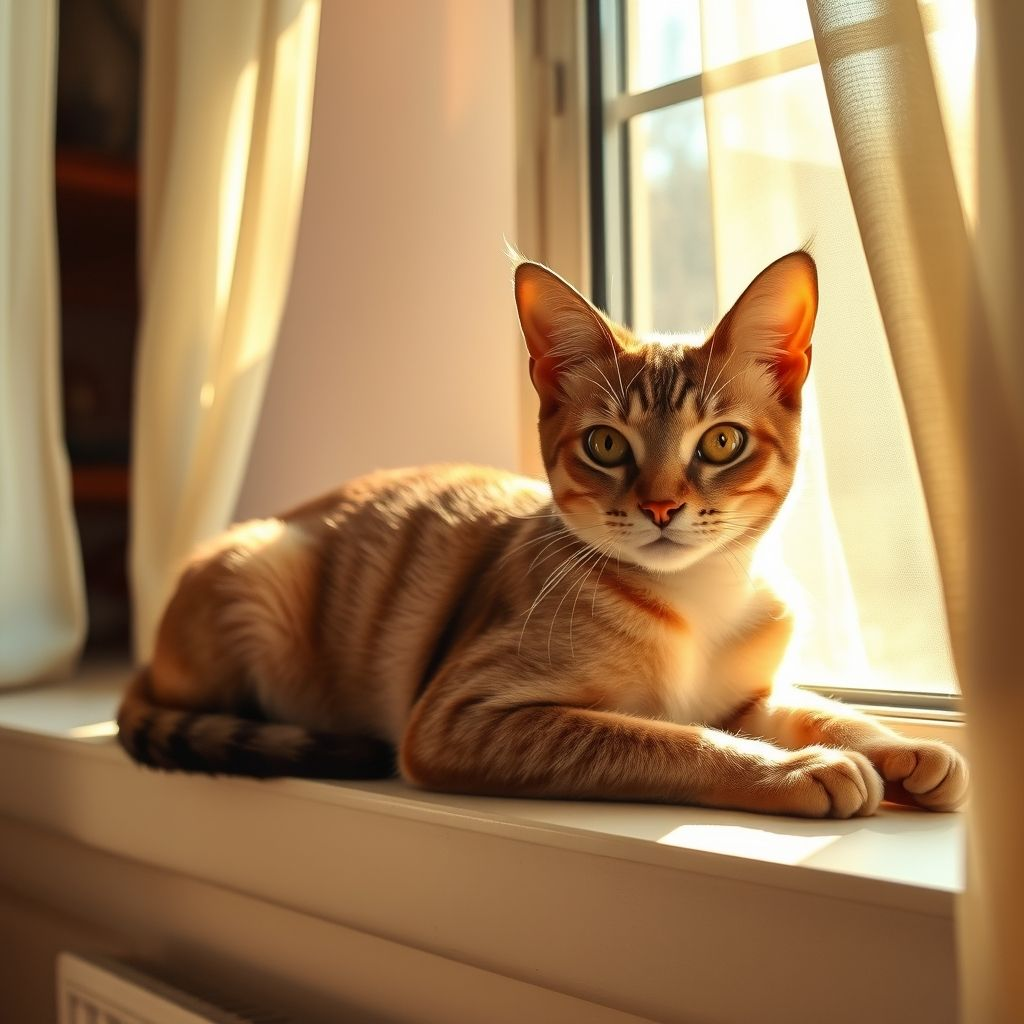

In [109]:
# demo1 1img = auto
await run_image_workflow("Generate 1 image : a smiley kitty.")